# Pytorch Model

### Let's talk about the model creation, training and prediction in Torch.

In [1]:
import torch                     # for all things PyTorch
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F  # for the activation function

## LeNet-5 Model
###  LeNet-5, one of the earliest convolutional neural network, and one of the drivers of the explosion in Deep Learning. It was built to read small images of handwritten numbers (the MNIST dataset), and correctly classify which digit was represented in the image.

In [2]:
#define the Lenet class

class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### The above script demonstrates the structure of a typical PyTorch model:

### It inherits from torch.nn.Module - modules may be nested - in fact, even the Conv2d and Linear layer classes inherit from torch.nn.Module.

### A model will have an __init__() function, where it instantiates its layers, and loads any data artifacts it might need (e.g., an NLP model might load a vocabulary).

### A model will have a forward() function. This is where the actual computation happens: An input is passed through the network layers and various functions to generate an output.

### Other than that, you can build out your model class like any other Python class, adding whatever properties and methods you need to support your model’s computation.

### Now, let's instantiate this object and run some inputs

In [3]:
# Instantiate the object
net = LeNet()
print(net)                         # what does the object tell us about itself?

input = torch.rand(1, 1, 32, 32)   # stand-in for a 32x32 black & white image
print('\nImage batch shape:')
print(input.shape)

output = net(input)                # we don't call forward() directly
print('\nRaw output:')
print(output)
print(output.shape)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Image batch shape:
torch.Size([1, 1, 32, 32])

Raw output:
tensor([[-0.1083, -0.0592,  0.0194, -0.0088, -0.0862,  0.0752, -0.0510, -0.0002,
         -0.0426, -0.0485]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


## Data set and Data loader

### Below, I am going to demonstrate using one of the ready-to-download, open-access datasets from TorchVision, - how to transform the images for consumption by your model, and how to use the DataLoader to feed batches of data to your model.

### The first thing we need to do is transform the incoming images into a PyTorch tensor.

In [4]:
#%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

### Next, I’ll create an instance of the CIFAR10 dataset. 
### This is a set of 32x32 color image tiles representing 10 classes of objects: 
### 6 of animals (bird, cat, deer, dog, frog, horse) and 4 of vehicles (airplane, automobile, ship, truck).

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data


### Now, since the dataset is ready, i have to give it to the data loader

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

### It’s a good practice to visualize the batches your DataLoader serves.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse   car   car truck


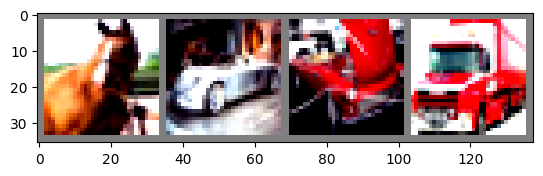

In [7]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # not-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Training my Pytorch Model

In [8]:
#%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

### First, I’ll need training and test datasets. 

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Check output on Data loader

 ship  ship horse   car


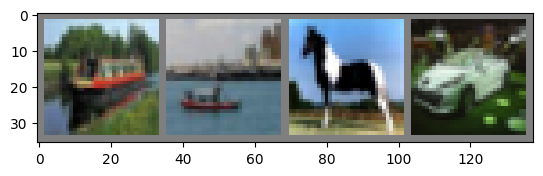

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Below is the Model I have to train

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [15]:
# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## let's all this to be assambled in training loop.

In [16]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.207
[1,  4000] loss: 1.861
[1,  6000] loss: 1.685
[1,  8000] loss: 1.583
[1, 10000] loss: 1.513
[1, 12000] loss: 1.457
[2,  2000] loss: 1.382
[2,  4000] loss: 1.378
[2,  6000] loss: 1.332
[2,  8000] loss: 1.310
[2, 10000] loss: 1.270
[2, 12000] loss: 1.261
Finished Training


## Note that:
### the loss is monotonically descending, indicating that the model is continuing to improve its performance on the training dataset.

### As a final step, I should check that the model is actually doing general learning, and not simply “memorizing” the dataset. This is called *overfitting*, and usually indicates that the dataset is too small (not enough examples for general learning), or that the model has more learning parameters than it needs to correctly model the dataset.

### This is the reason datasets are split into training and test subsets - to test the generality of the model, we ask it to make predictions on data it hasn’t trained on.

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


### one should see that the model is roughly 50% accurate at this point. 
### That’s not exactly state-of-the-art, but it’s far better than the 10% accuracy we’d expect from a random output. This demonstrates that some general learning did happen in the model.